In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/ml-challenge/train.csv
/kaggle/input/ml-challenge/test.csv


In [2]:
import gc
!pip install autokeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.4/162.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:0000:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requ

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import BertPreTrainedModel, BertModel
from transformers import AutoConfig, AutoTokenizer

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange

import re

In [5]:
import autokeras
from autokeras import TextRegressor
text_reg = TextRegressor(overwrite=True, max_trials=1)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
dftrain = pd.read_csv('/kaggle/input/ml-challenge/train.csv')
dftest = pd.read_csv('/kaggle/input/ml-challenge/test.csv')


In [46]:
plt.style.use('dark_background')

In [8]:
train_data, validation = train_test_split(dftrain, test_size=0.1, random_state=21)

In [9]:
dftrain.shape, dftest.shape

((2249698, 6), (734736, 5))

In [47]:
gc.collect()

326

In [48]:
dftrain = dftrain.dropna()

In [97]:
dftrain.head()

,PRODUCT_TYPE_ID,PRODUCT_LENGTH,input
0,7537,748.031495,PRIKNIK Horn Red Electric Air Horn Compressor ...
1,2996,787.401574,ALISHAH Women's Cotton Ankle Length Leggings C...
2,5725,950.000000,HINS Metal Bucket Shape Plant Pot for Indoor &...
3,6030,984.251967,Delavala Self Adhesive Kitchen Backsplash Wall...
4,8201,393.700787,Hexwell Essential oil for Home Fragrance Oil A...


In [50]:
dftrain['input'] = dftrain['TITLE']+dftrain['BULLET_POINTS']#+dftrain['DESCRIPTION']

In [54]:
dftrain.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,input
0,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495,PRIKNIK Horn Red Electric Air Horn Compressor ...
1,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574,ALISHAH Women's Cotton Ankle Length Leggings C...
2,2152929,HINS Metal Bucket Shape Plant Pot for Indoor &...,"[Simple and elegant, great for displaying indo...",HINS Brings you the most Elegant Looking Pot w...,5725,950.000000,HINS Metal Bucket Shape Plant Pot for Indoor &...
3,2026580,Delavala Self Adhesive Kitchen Backsplash Wall...,[HIGH QUALITY PVC MATERIAL: The kitchen alumin...,<p><strong>Aluminum Foil Stickers-good kitchen...,6030,984.251967,Delavala Self Adhesive Kitchen Backsplash Wall...
4,2998633,Hexwell Essential oil for Home Fragrance Oil A...,[100% Pure And Natural Essential Oil Or Fragra...,"Transform your home, workplace or hotel room i...",8201,393.700787,Hexwell Essential oil for Home Fragrance Oil A...


In [52]:
dftrain=dftrain.reset_index()

In [53]:
dftrain=dftrain.drop(['index'],axis=1)

In [55]:
def cleantext(text):
  
    text = re.sub('https?://\S+|www\.\S+', '', text)#remove the links
    text = re.sub('<.*?>+', '', text)#remove the expressions inside the angular brackets like XML and HTML tags
    return text

In [19]:
dftrain['input'] = dftrain['input'].astype(str)

In [20]:
dftrain.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,input
0,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495,PRIKNIK Horn Red Electric Air Horn Compressor ...
1,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574,ALISHAH Women's Cotton Ankle Length Leggings C...
2,2152929,HINS Metal Bucket Shape Plant Pot for Indoor &...,"[Simple and elegant, great for displaying indo...",HINS Brings you the most Elegant Looking Pot w...,5725,950.000000,HINS Metal Bucket Shape Plant Pot for Indoor &...
3,2026580,Delavala Self Adhesive Kitchen Backsplash Wall...,[HIGH QUALITY PVC MATERIAL: The kitchen alumin...,<p><strong>Aluminum Foil Stickers-good kitchen...,6030,984.251967,Delavala Self Adhesive Kitchen Backsplash Wall...
4,2998633,Hexwell Essential oil for Home Fragrance Oil A...,[100% Pure And Natural Essential Oil Or Fragra...,"Transform your home, workplace or hotel room i...",8201,393.700787,Hexwell Essential oil for Home Fragrance Oil A...


In [56]:
dftrain['input'] = dftrain['input'].apply(lambda x:cleantext(x))

In [23]:
dftrain['input']

0       PRIKNIK Horn Red Electric Air Horn Compressor ...
1       ALISHAH Women's Cotton Ankle Length Leggings C...
2       HINS Metal Bucket Shape Plant Pot for Indoor &...
3       Delavala Self Adhesive Kitchen Backsplash Wall...
4       Hexwell Essential oil for Home Fragrance Oil A...
                              ...                        
9995    Hug n Feel Long Soft Rainbow Teddy Cute Giant ...
9996    Aimex Heavy Duty Electric Screwdriver 280W, 78...
9997    Xuanbeier Rotation Case Compatible with Remark...
9998    Us Army Soldier Ww2 (Sku57) Battle Brick Minif...
9999    bestbuy Portable Double Layers Rectangular Med...
Name: input, Length: 10000, dtype: object

In [24]:
dftrain.dropna()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,input
0,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495,PRIKNIK Horn Red Electric Air Horn Compressor ...
1,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574,ALISHAH Women's Cotton Ankle Length Leggings C...
2,2152929,HINS Metal Bucket Shape Plant Pot for Indoor &...,"[Simple and elegant, great for displaying indo...",HINS Brings you the most Elegant Looking Pot w...,5725,950.000000,HINS Metal Bucket Shape Plant Pot for Indoor &...
3,2026580,Delavala Self Adhesive Kitchen Backsplash Wall...,[HIGH QUALITY PVC MATERIAL: The kitchen alumin...,<p><strong>Aluminum Foil Stickers-good kitchen...,6030,984.251967,Delavala Self Adhesive Kitchen Backsplash Wall...
4,2998633,Hexwell Essential oil for Home Fragrance Oil A...,[100% Pure And Natural Essential Oil Or Fragra...,"Transform your home, workplace or hotel room i...",8201,393.700787,Hexwell Essential oil for Home Fragrance Oil A...
...,...,...,...,...,...,...,...
9995,2859682,Hug n Feel Long Soft Rainbow Teddy Cute Giant ...,[✔️Soft plush Doll made of high quality plush ...,Colour of the actual product may slightly vary...,1117,3937.007870,Hug n Feel Long Soft Rainbow Teddy Cute Giant ...
9996,2622513,"Aimex Heavy Duty Electric Screwdriver 280W, 78...",[Power: 280W; No Load Speed: 0-780 RPM; Max Dr...,The Electric Drill Is Very Skillfully Designed...,9800,937.007873,"Aimex Heavy Duty Electric Screwdriver 280W, 78..."
9997,2331671,Xuanbeier Rotation Case Compatible with Remark...,[Compatibility: Compatible with Remarkable 2 1...,<b>Compatibility:</b> Compatible with Remarkab...,607,992.124000,Xuanbeier Rotation Case Compatible with Remark...
9998,1022431,Us Army Soldier Ww2 (Sku57) Battle Brick Minif...,"[Us Army Soldier,Made from durable material,Ba...",Battle Brick Minifigure Made from durable mate...,227,100.000000,Us Army Soldier Ww2 (Sku57) Battle Brick Minif...


In [57]:
word_count = dftrain['input'].apply(lambda x: len(x.split()))

In [58]:
big = dftrain

In [49]:
dftrain = dftrain[0:1000]

In [26]:
dftrain['PRODUCT_LENGTH']=dftrain['PRODUCT_LENGTH'].astype(float)
dftrain['PRODUCT_ID']=dftrain['PRODUCT_ID'].astype(float)
dftrain['PRODUCT_TYPE_ID']=dftrain['PRODUCT_TYPE_ID'].astype(float)

In [58]:
dftrain=dftrain.drop(['PRODUCT_ID','TITLE','BULLET_POINTS',	'DESCRIPTION'],axis=1)

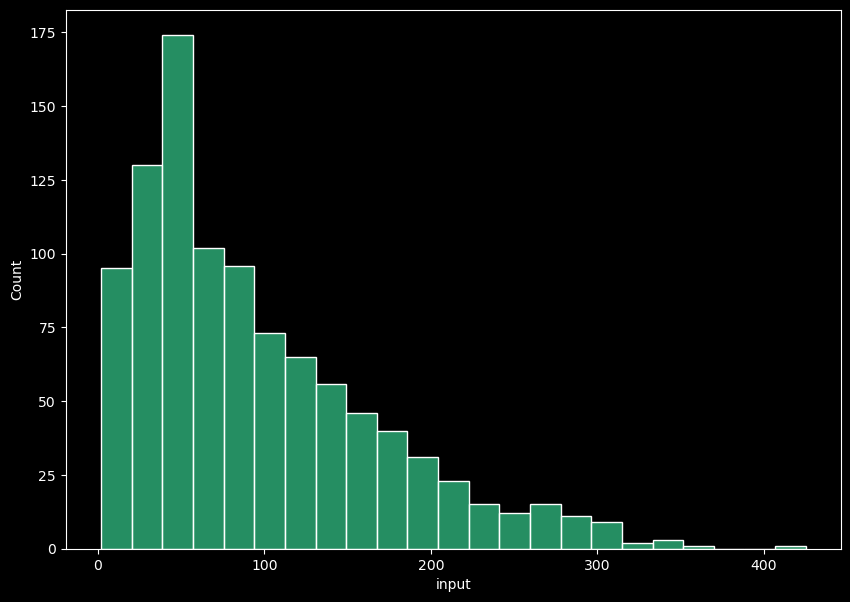

In [59]:
fig = plt.figure(figsize=[10,7])
sns.histplot(word_count, color=sns.xkcd_rgb['greenish teal'])
plt.show()

In [60]:
dftrain.dtypes

PRODUCT_TYPE_ID      int64
PRODUCT_LENGTH     float64
input               object
dtype: object

In [47]:
dftrain['input']=dftrain['input'].astype(str)

In [30]:
gc.collect()


136

In [34]:
pip install keras --upgrade


Note: you may need to restart the kernel to use updated packages.


In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [38]:
pip install lightgbm --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.3.2
    Uninstalling lightgbm-3.3.2:
      Successfully uninstalled lightgbm-3.3.2
Note: you may need to restart the kernel to use updated packages.


In [61]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


# Load the pre-trained GloVe word embeddings
embeddings_index = {}
with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dftrain['input'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(dftrain['input'])
max_length = 100 # Set the maximum length of the sequences
data = pad_sequences(sequences, maxlen=max_length)

# Create an embedding matrix
num_words = len(word_index) + 1
embedding_dim = 100 # Use the same dimension as the GloVe vectors
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(data, dftrain['PRODUCT_LENGTH'], test_size=0.2, random_state=42)

# Convert the data into LightGBM's format
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

# Define the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Set the embedding matrix as a fixed feature
fixed_feature_params = {'feature_name': 'embedding', 'feature_is_categorical': False, 'max_bin': 255}
fixed_feature_values = embedding_matrix[X_train.reshape(-1)].reshape(X_train.shape[0], max_length, embedding_dim)
fixed_feature_valid_values = embedding_matrix[X_valid.reshape(-1)].reshape(X_valid.shape[0], max_length, embedding_dim)

# Train the LightGBM model
lgb_model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, valid_data], early_stopping_rounds=10)

# Make predictions on the validation set
y_pred = lgb_model.predict(X_valid)

# Evaluate the model
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error:", mse)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 6.48542e+06	valid_1's l2: 3.2284e+06
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 6.39457e+06	valid_1's l2: 3.20706e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 6.32214e+06	valid_1's l2: 3.22993e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 6.25394e+06	valid_1's l2: 3.23895e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's l2: 6.19356e+06	valid_1's l2: 3.257e+06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's l2: 6.15154e+06	valid_1's l

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [63]:
import numpy as np
import pandas as pd
import xgboost as xgb
from keras.preprocessing.text import Tokenizer

# Load pre-trained GloVe embeddings
embeddings_index = {}
with open('/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Tokenize text data and convert to sequences of word indices
max_features = 10000 # number of unique words to use as features
maxlen = 100 # maximum length of each sequence
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(dftrain['input']) # dftrain['input'] contains text data
sequences = tokenizer.texts_to_sequences(dftrain['input'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Pad sequences to have same length
data = pad_sequences(sequences, maxlen=maxlen)

# Create embeddings matrix for XGBoost
embedding_dim = 100 # dimension of the GloVe embeddings used
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Prepare training data
X = data
y = dftrain['PRODUCT_LENGTH'] # target variable
dtrain = xgb.DMatrix(X, label=y)

# Train XGBoost model
params = {
    'max_depth': 6,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'subsample': 0.5,
    'colsample_bytree': 0.5
}
model = xgb.train(params, dtrain)


Found 11547 unique tokens.


In [66]:
X_val = pad_sequences(tokenizer.texts_to_sequences(dftrain['input']), maxlen=maxlen)
y_val = dftrain['PRODUCT_LENGTH']

# Make predictions on validation data
dval = xgb.DMatrix(X_val)
y_pred = model.predict(dval)

# Calculate mean squared error of predictions
mse = mean_squared_error(y_val, y_pred)
print('Mean squared error: ', mse)

Mean squared error:  4137248.6580936452


In [51]:
dftest=pd.read_csv("/kaggle/input/ml-challenge/test.csv")

In [67]:
dftest.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID
0,604373,Manuel d'Héliogravure Et de Photogravure En Re...,NaN,NaN,6142
1,1729783,DCGARING Microfiber Throw Blanket Warm Fuzzy P...,[QUALITY GUARANTEED: Luxury cozy plush polyest...,<b>DCGARING Throw Blanket</b><br><br> <b>Size ...,1622
2,1871949,I-Match Auto Parts Front License Plate Bracket...,"[Front License Plate Bracket Made Of Plastic,D...",Replacement for The Following Vehicles:2020 LE...,7540
3,1107571,PinMart Gold Plated Excellence in Service 1 Ye...,[Available as a single item or bulk packed. Se...,Our Excellence in Service Lapel Pins feature a...,12442
4,624253,"Visual Mathematics, Illustrated by the TI-92 a...",NaN,NaN,6318


In [68]:
dftest=dftest.fillna(" ")

In [69]:
dftest['input']=dftest['TITLE']+dftest['BULLET_POINTS']

In [70]:
dftest['input'] = dftest['input'].apply(lambda x:cleantext(x))

In [71]:
dftest["input"]=dftest["input"].astype(str)

In [67]:
dftest['input'].head()

0    Manuel d H liogravure Et de Photogravure En Re...
1    DCGARING Microfiber Throw Blanket Warm Fuzzy P...
2    I Match Auto Parts Front License Plate Bracket...
3    PinMart Gold Plated Excellence in Service   Ye...
4    Visual Mathematics  Illustrated by the TI    a...
Name: input, dtype: object

In [98]:
y_pred.shape

(734736,)

In [102]:
df = pd.DataFrame(y_pred)


In [108]:
df['PRODUCT_ID']=dftest["PRODUCT_ID"]

In [106]:
df=df.rename(columns={0:'PRODUCT_LENGTH'})

In [112]:
df=df.reindex(columns=['PRODUCT_ID', 'PRODUCT_LENGTH'])

In [113]:
df.to_csv('my_data2.csv', index=False)

In [109]:
df.head()

,PRODUCT_LENGTH,PRODUCT_ID
0,1200.599731,604373
1,754.230103,1729783
2,593.169861,1871949
3,1481.883667,1107571
4,1188.786255,624253
